# Comparison of Models w/ Different Lambdas

In [1]:
! pip install keras
! pip install matplotlib
! pip install pandas
! pip install seaborn
! pip install pydrive
! pip install tensorflow
! pip install bottleneck

    100% |████████████████████████████████| 276kB 3.0MB/s ta 0:00:01
    100% |████████████████████████████████| 256kB 3.2MB/s ta 0:00:01
    100% |████████████████████████████████| 16.9MB 77kB/s  eta 0:00:01
    100% |████████████████████████████████| 47.9MB 26kB/s  eta 0:00:01    38% |████████████▎                   | 18.3MB 64.5MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 15.0MB 89kB/s  eta 0:00:01
    100% |████████████████████████████████| 491kB 3.1MB/s eta 0:00:01
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |███████████████████████████

In [1]:
from keras import backend as K
from keras import regularizers
import nregularizer
import numpy as np
from gensim_download import pickle_rw
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt

import pandas as pd

import numpy.linalg

from numpy.linalg import det

from numpy.linalg import inv


import pandas as pd
%matplotlib inline
import seaborn as sns; sns.set()

import bottleneck as bn


Using TensorFlow backend.


### Defining Functions

In [12]:
def make_dict(vocab, vectors):
    """Make dictionary of vocab and vectors"""
    return {vocab[i]: vectors[i] for i in range(len(vocab))}


def vocab_train_test(embedding, lg1, lg2, lg1_vocab):
    """Create training and test vocabularies"""
    if embedding == 'zeroshot':
        with open('../data/zeroshot/transmat/data/' +
                  'OPUS_en_it_europarl_train_5K.txt') as f:
            vocab_train = [(_.split(' ')[0], _.split(' ')[1])
                           for _ in f.read().split('\n')[:-1]]
        with open('../data/zeroshot/transmat/data/' +
                  'OPUS_en_it_europarl_test.txt') as f:
            vocab_test = [(_.split(' ')[0], _.split(' ')[1])
                          for _ in f.read().split('\n')[:-1]]

    elif embedding in ['fasttext_random', 'fasttext_top']:
        embedding, split = embedding.split('_')
        lg1_lg2, lg2_lg1 = pickle_rw((lg1 + '_' + lg2, 0),
                                     (lg2 + '_' + lg1, 0), write=False)
        # T = Translation, R = Reverse (translated and then translated back)
        # Create vocab from 2D translations
        vocab_2D = []
        for lg1_word in lg1_vocab:
            # Translate lg1_word
            if lg1_word in lg1_lg2:
                lg1_word_T = lg1_lg2[lg1_word]

                # Check if translated word (or lowercase) is in lg2_lg1
                if lg1_word_T in lg2_lg1.keys():
                    lg1_word_R = lg2_lg1[lg1_word_T]
                elif lg1_word_T.lower() in lg2_lg1.keys():
                    lg1_word_T = lg1_word_T.lower()
                    lg1_word_R = lg2_lg1[lg1_word_T]
                else:
                    lg1_word_R = None

                # Check if lg1_word and lg1_word_R are equal (lowercase)
                if lg1_word_R:
                    if lg1_word.lower() == lg1_word_R.lower():
                        vocab_2D.append((lg1_word, lg1_word_T))
        print('length of '+ lg1+'-'+ lg2+ ' vocab: '+str(len(vocab_2D)))

        #Create Train/Test vocab

        if split == 'random':
            sample = np.random.choice(len(vocab_2D), 6500, replace=False)
            vocab_train = np.asarray(vocab_2D)[sample[:5000]].tolist()
            vocab_test = np.asarray(vocab_2D)[sample[5000:]].tolist()
        elif split == 'top':
#             sample = np.random.choice(range(6500), 6500, replace=False)
            vocab_train = np.asarray(vocab_2D)[:5000, :].tolist()
            vocab_test = np.asarray(vocab_2D)[:1500, :].tolist()
            
#             sample = np.random.choice(range(6500), 6500, replace=False)
#             vocab_train = np.asarray(vocab_2D)[:700, :].tolist()
#             vocab_test = np.asarray(vocab_2D)[:200, :].tolist()
        else:
            pass

        # if split == 'random':
        #     sample = np.random.choice(len(vocab_2D), 900, replace=False)
        #     vocab_train = np.asarray(vocab_2D)[sample[:700]].tolist()
        #     vocab_test = np.asarray(vocab_2D)[sample[700:]].tolist()
        # elif split == 'top':
        #     sample = np.random.choice(range(900), 900, replace=False)
        #     vocab_train = np.asarray(vocab_2D)[:700, :].tolist()
        #     vocab_test = np.asarray(vocab_2D)[:200, :].tolist()
        # else:
        #     pass

    return vocab_train, vocab_test


def vectors_train_test(vocab_train, vocab_test):
    """Create training and test vectors"""
    X_train, y_train = zip(*[(lg1_dict[lg1_word], lg2_dict[lg2_word])
                             for lg1_word, lg2_word in vocab_train])
    X_test, y_test = zip(*[(lg1_dict[lg1_word], lg2_dict[lg2_word])
                           for lg1_word, lg2_word in vocab_test])
    return map(np.asarray, (X_train, X_test, y_train, y_test))




def translation_matrix(X_train, y_train, l):
    """Fit translation matrix T"""
    #def norm_reg(weight_matrix):
     #   return 0.01 * np.linalg.norm(np.matrix(np.subtract(np.matmul(weight_matrix,weight_matrix.T,np.matmul(weight_matrix.T,weight_matrix))),'fro')
    model = Sequential()
    model.add(Dense(300, use_bias=False, input_shape=(X_train.shape[1],),kernel_regularizer=nregularizer.l3(l)))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, batch_size=128, epochs=20,
                        verbose=False)
    T = model.get_weights()[0]
    
    M = np.matrix(T)

    Fr_norm = np.linalg.norm(np.matrix(np.subtract(np.matmul(M,np.transpose(M)),np.matmul(np.transpose(M),M))),'fro')

    #print ("Determinant:"+str(D))
    
    #print ("Fr_norm:"+str(Fr_norm))

    return T, Fr_norm 

def translation_matrix_nonreg(X_train, y_train):
    """Fit translation matrix T"""
    model = Sequential()
    model.add(Dense(300, use_bias=False, input_shape=(X_train.shape[1],)))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, batch_size=128, epochs=20,
                        verbose=False)
    T = model.get_weights()[0]
    M = np.matrix(T)
    D = np.linalg.det(T)
    Fr_norm = np.linalg.norm(np.matrix(np.subtract(np.matmul(M,np.transpose(M)),np.matmul(np.transpose(M),M))),'fro')

    return T, Fr_norm

def translation_accuracy(X_test, y_test, T):
    """Get predicted matrix 'yhat' using 'T' and find translation accuracy"""
    # yhat
    yhat = X_test.dot(T)
    count = 0
    for i in range(len(y_test)):
        #if yhat[i,:].all() == y_test[i,:].all():
        if np.array_equal(yhat[i,:],y_test[i,:]) == True:
            count = count + 1
    accuracy = count/len(y_test)*100
    return accuracy

def svd(T):
    """Perform SVD on the translation matrix 'T' """
    U, s, Vh = numpy.linalg.svd(T, full_matrices=False )
    return U, s, Vh

def T_svd_EDA(s):
    """Perform SVD on the translation matrix 'T' """
    plt.hist(s, bins='auto', range = (0,1),normed = 1)
    plt.show()




def normalize(matrix):
    """Normalize the rows of a matrix"""
    matrix_norm = np.linalg.norm(matrix, axis=1)
    matrix_normed = matrix / np.repeat(matrix_norm, matrix.shape[1]). \
        reshape(matrix.shape)
    return matrix_norm, matrix_normed


def translation_results(X, y, vocab, T, lg2_vectors, lg2_vocab):
    """X, y, vocab - The training or test data that you want results for
    T - The translation matrix
    lg2_vectors, lg2_vocab - Foreign language used to find the nearest neighbor
    """
    print("in translation results.... and doing data prep")
    # Data Prep on Inputs
    X_word, y_word = zip(*vocab)
    X_norm, X_normed = normalize(X)
    y_norm, y_normed = normalize(y)
    lg2_vectors_norm, lg2_vectors_normed = normalize(lg2_vectors)

    print("yhat")
    # yhat
    yhat = X.dot(T)
    yhat_norm, yhat_normed = normalize(yhat)

    #X_norm = normalize(X)

    print("neg_cosine and ")
    # Nearest Neighbors
    neg_cosine = -yhat_normed.dot(lg2_vectors_normed.T)
    
    print("ranked neighbor indices")
    #ranked_neighbor_indices = np.argsort(neg_cosine, axis=1)
    ranked_neighbor_indices = bn.argpartition(neg_cosine, 1, axis = 1 )
    # Nearest Neighbor
    print("step 1:nn indices...")
    nearest_neighbor_indices = ranked_neighbor_indices[:, 0]
    print("step 2:yhat_neighbor...")
    yhat_neighbor = lg2_vectors[nearest_neighbor_indices, :]
    print("step 3:yhat_neighbor_norm...")
    yhat_neighbor_norm, yhat_neighbor_normed = normalize(yhat_neighbor)
    print("step 4:yhat_neighbor_word...")
    yhat_neighbor_word = np.asarray(lg2_vocab)[nearest_neighbor_indices]

    # Results DF
    print("step 5:making df....")
    cols = ['X_norm', 'y_norm', 'yhat_norm', 'yhat_neighbor_norm',
            'X_word', 'y_word', 'yhat_neighbor_word']
    results_df = pd.DataFrame({'X_norm': X_norm,
                               'y_norm': y_norm,
                               'yhat_norm': yhat_norm,
                               'yhat_neighbor_norm': yhat_neighbor_norm,
                               'X_word': X_word,
                               'y_word': y_word,
                               'yhat_neighbor_word': yhat_neighbor_word,})
    results_df = results_df[cols]
    results_df['neighbor_correct'] = results_df.y_word == \
        results_df.yhat_neighbor_word

    return results_df

def T_norm_EDA(results_df):
    """Plot result norms side-by-side"""
    
    test_size = results_df.shape[0]
    test_accuracy = round(results_df.neighbor_correct.mean(), 2)

    #print('Test Accuracy: '+str(test_accuracy)+'\n')

    #plot_data = ['X_norm', 'y_norm', 'yhat_norm', 'yhat_neighbor_norm']
    # f, ax = plt.subplots(len(plot_data), sharex=True, sharey=True,
    #                      figsize=(10, 10))
    # for i, d in enumerate(plot_data):
    #     ax[i].hist(results_df[d], bins=100)
    #     ax[i].axis('off')
    #     title = '{}: mean={}, std={}'.format(d, round(results_df[d].mean(), 2), round(results_df[d].std(), 2))
    #     ax[i].set_title(title)
    # f.subplots_adjust(hspace=0.7)
    # plt.savefig('../images/' + lg1 + '_' + lg2 + '_' + embedding +
    #             '_T_norm.png')
    # plt.close('all')
    return test_accuracy


def T_pca_EDA(T):
    """PCA on matrix T"""
    T_ss = StandardScaler().fit_transform(T)
    pca = PCA().fit(T_ss)
    n = pca.n_components_

    # plt.figure(figsize=(10, 6))
    # plt.xlim((0, n))
    # plt.ylim((0, 1))
    # plt.plot(range(n + 1), [0] + np.cumsum(pca.explained_variance_ratio_).
    #          tolist())
    # plt.plot(range(n + 1), np.asarray(range(n + 1)) / n)
    # plt.xlabel('Number of Eigenvectors')
    # plt.ylabel('Explained Variance')
    # plt.savefig('../images/' + lg1 + '_' + lg2 + '_' + embedding +
    #             '_T_isotropy.png')
    # plt.close('all')

    isotropy = (1 - sum(np.cumsum(pca.explained_variance_ratio_) * 1 / n)) / .5
    return isotropy


def T_report_results(embedding, lg1, lg2, lg1_vectors, lg2_vectors,
                     X_train, X_test, D, results_df, isotropy):
    md = '## ' + lg1.title() + ' to ' + lg2.title() + ' ' + \
        embedding.title() + '  \n'
    md += '- ' + lg1.title() + ' Vocabulary Size = ' + \
        '{:,.0f}'.format(lg1_vectors.shape[0]) + '  \n'
    md += '- ' + lg1.title() + ' Embedding Length = ' + \
        '{:,.0f}'.format(lg1_vectors.shape[1]) + '  \n'
    md += '- ' + lg2.title() + ' Vocabulary Size = ' + \
        '{:,.0f}'.format(lg2_vectors.shape[0]) + '  \n'
    md += '- ' + lg2.title() + ' Embedding Length = ' + \
        '{:,.0f}'.format(lg2_vectors.shape[1]) + '  \n'
    md += '- Train Size = ' + '{:,.0f}'.format(X_train.shape[0]) + '  \n'
    md += '- Test Size = ' + '{:,.0f}'.format(X_test.shape[0]) + '  \n'
    md += '- Determinant = ' + '{:,.0f}'.format(D) + '  \n'

    md += '- <b>Test Accuracy = ' + \
        '{:,.1%}'.format(results_df.neighbor_correct.mean()) + '</b>  \n\n'



    md += '#### Test L2 Norms  \n'
    md += '- X_norm: L2 norms for ' + lg1.title() + ' test vectors  \n'
    md += '- y_norm: L2 norms for ' + lg2.title() + ' test vectors  \n'
    md += '- yhat_norm: L2 norms for X.dot(T) test vectors ' + \
        '(T = translation matrix)  \n'
    md += '- yhat_neighbor norm: L2 norms for nearest neighbor' + \
        'to X.dot(T) in y test vectors  \n'
    md += '![](../images/' + lg1 + '_' + lg2 + '_' + embedding + \
        '_T_norm.png)  \n\n'

    md += '#### Translation Matrix Isotropy  \n'
    md += '- Isotropy = ' + '{:,.1%}'.format(isotropy) + '  \n'
    md += '![](../images/' + lg1 + '_' + lg2 + '_' + embedding + \
        '_T_isotropy.png)  \n\n'

    return md

### Main Function

Translation: en->en

length of en-en vocab: 49999
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
1.0
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.0
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.99
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
1.0
in translation results.... and doing data prep
yhat
neg_cosine and 
r

step 4:yhat_neighbor_word...
step 5:making df....
0.62
Translation: ru->ru

length of ru-ru vocab: 50000
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
1.0
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.0
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.99
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
1.0
in translation

/opt/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Translation: de->ru

length of de-ru vocab: 5910
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.44
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.0
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.04
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.34
in translation results.... and doing data prep
yhat
neg_cosine and 


step 5:making df....
0.47
Translation: es->de

length of es-de vocab: 11456
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.54
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.0
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.04
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.42
in translation results.... and doing data

step 5:making df....
0.09
Translation: zh-CN->es

length of zh-CN-es vocab: 1164
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.15
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.0
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.0
in translation results.... and doing data prep
yhat
neg_cosine and 
ranked neighbor indices
step 1:nn indices...
step 2:yhat_neighbor...
step 3:yhat_neighbor_norm...
step 4:yhat_neighbor_word...
step 5:making df....
0.01
in translation results.... and doing 

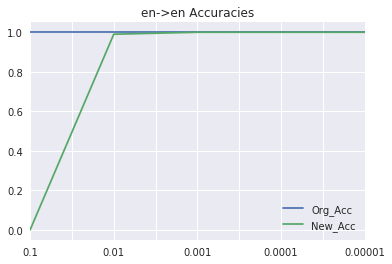

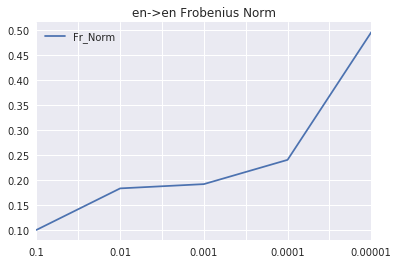

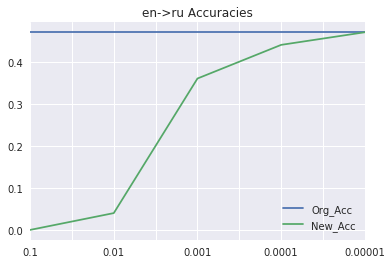

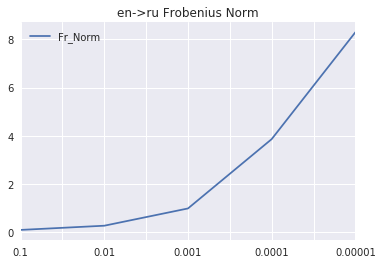

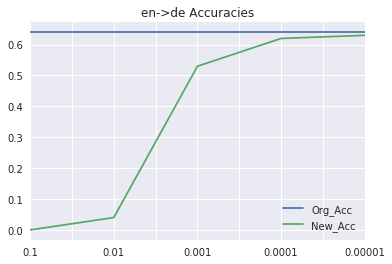

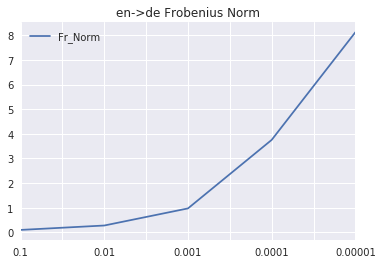

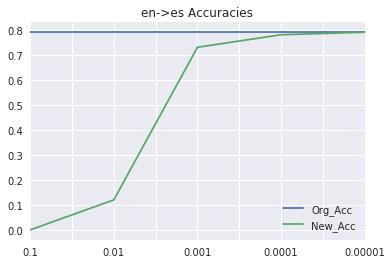

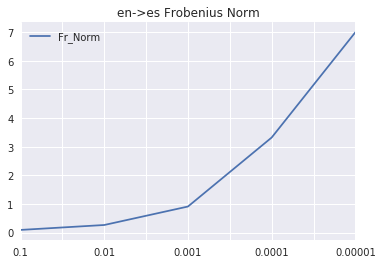

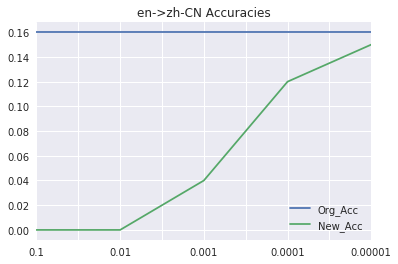

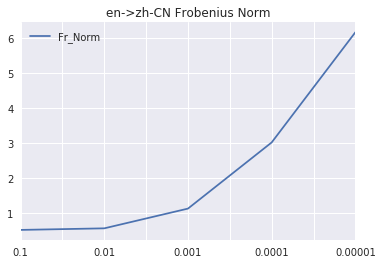

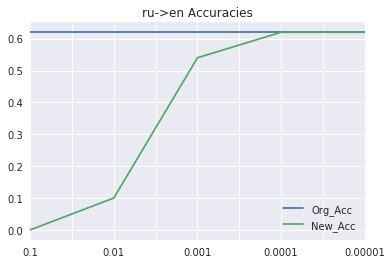

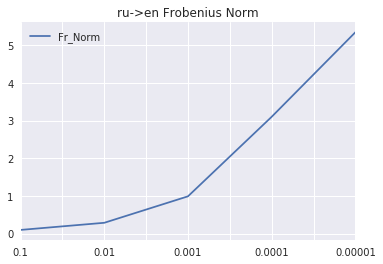

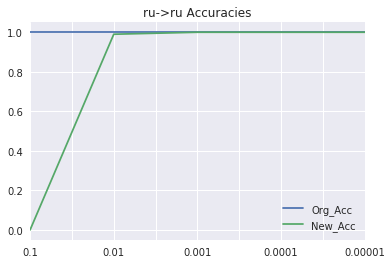

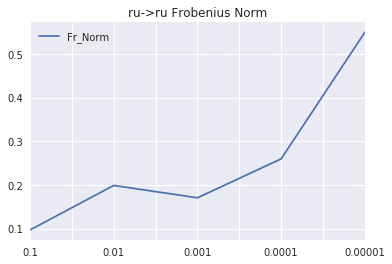

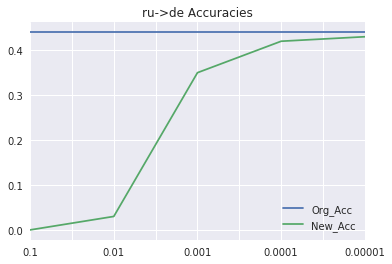

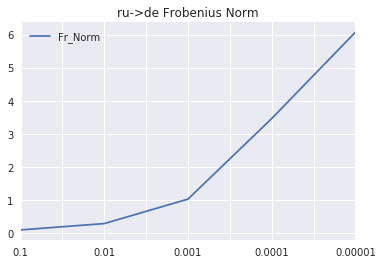

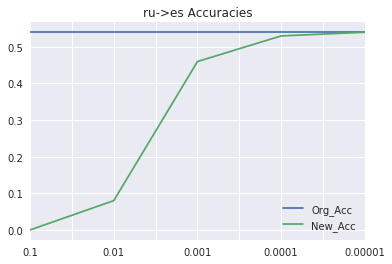

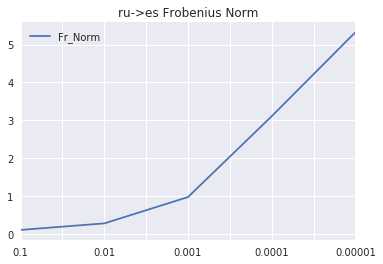

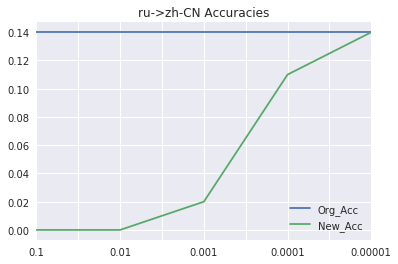

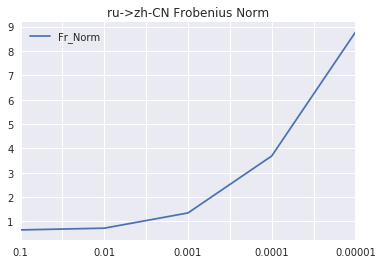

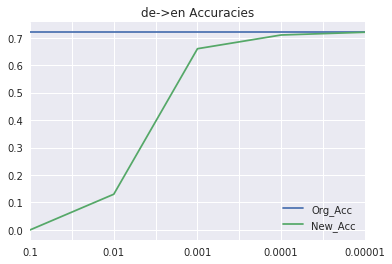

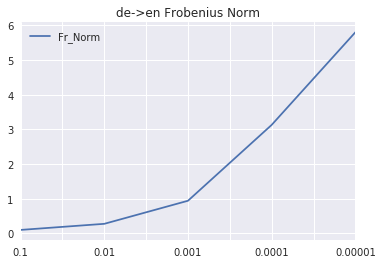

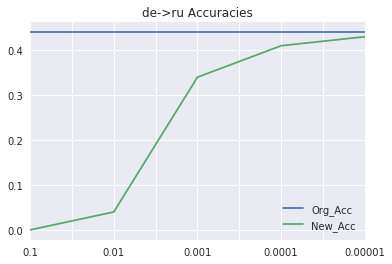

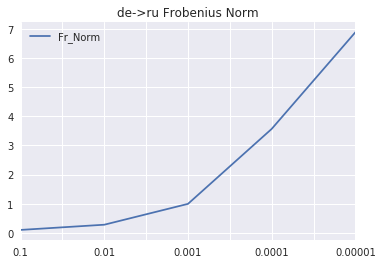

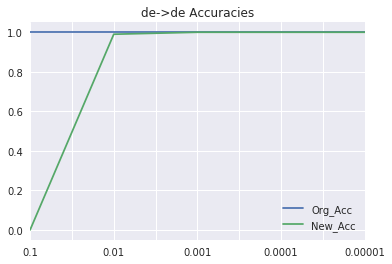

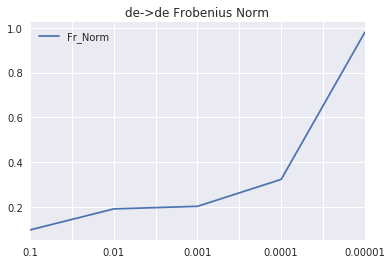

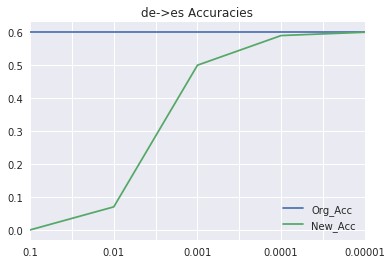

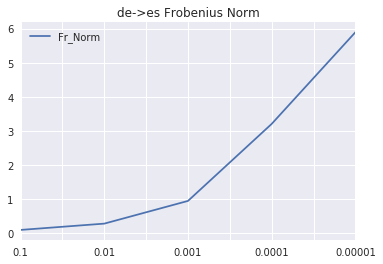

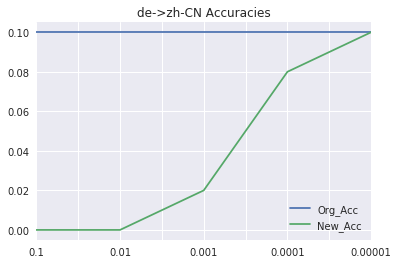

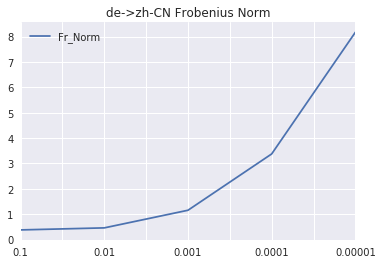

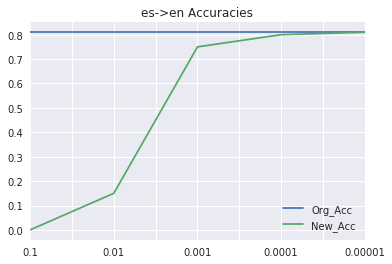

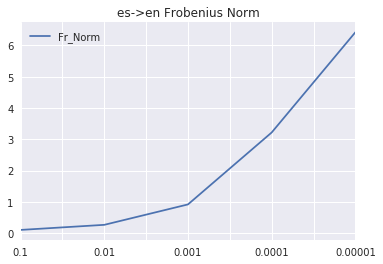

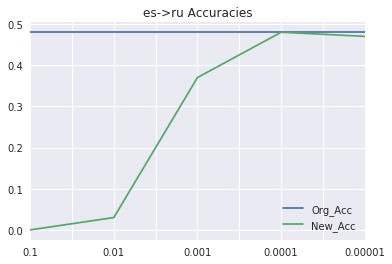

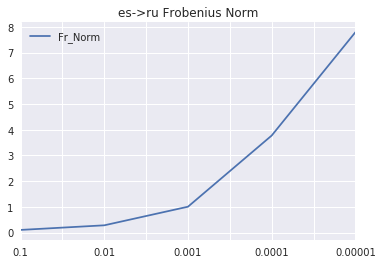

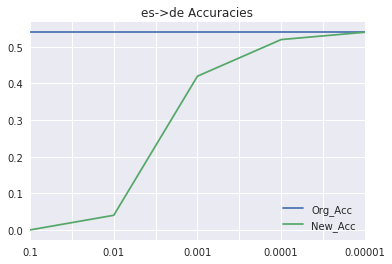

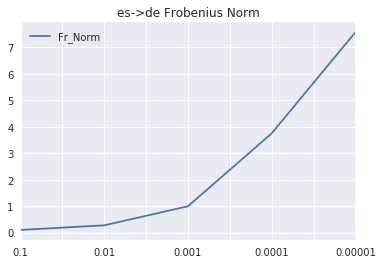

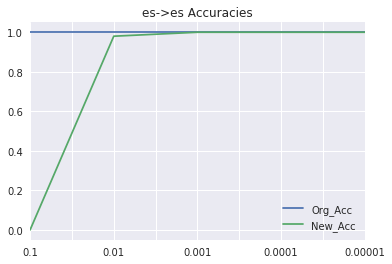

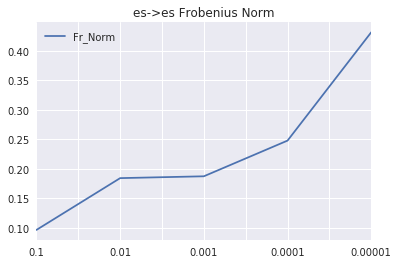

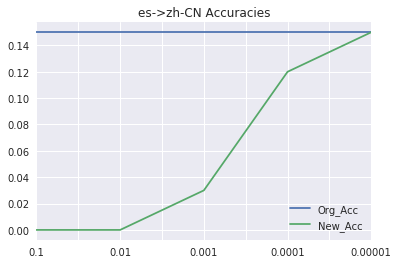

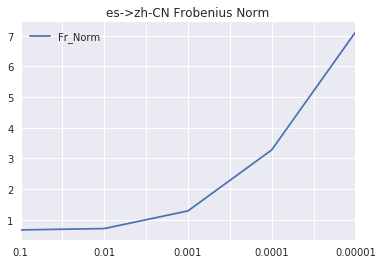

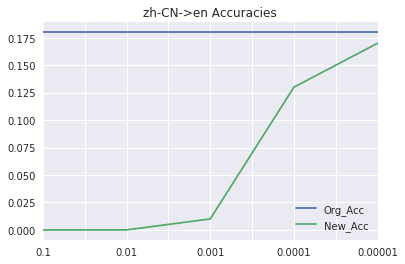

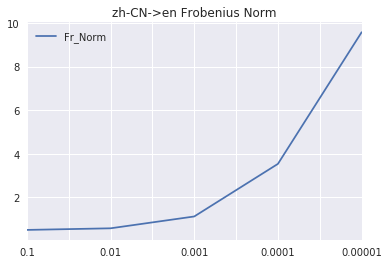

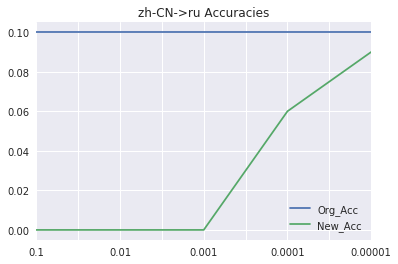

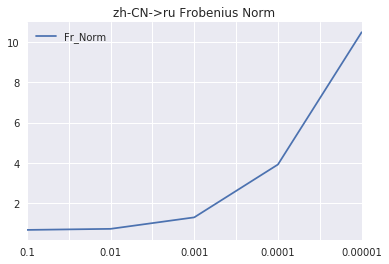

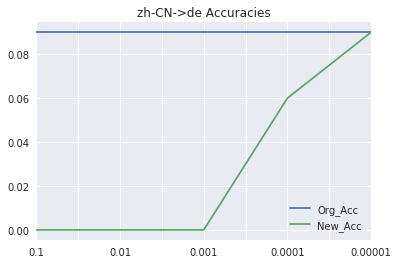

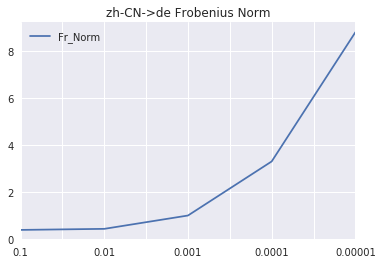

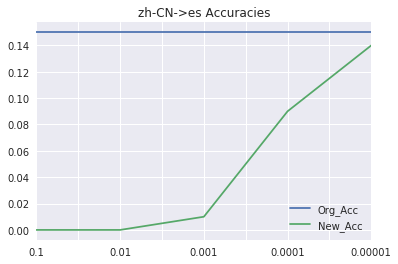

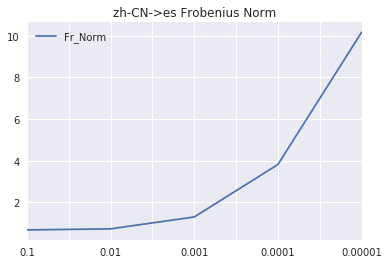

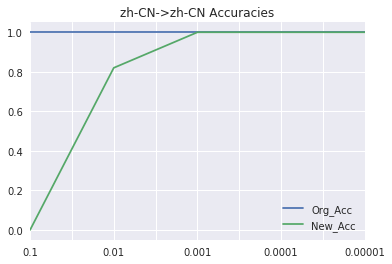

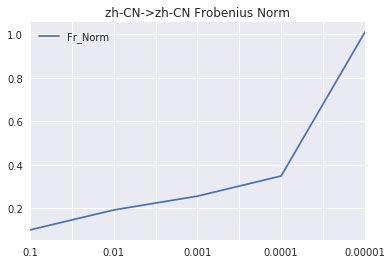

In [13]:
if __name__ == '__main__':
    # Manually set list of translations (embedding, lg1, lg2)
    translations = [#('fasttext_random', 'en', 'ru'),
                    ('fasttext_top', 'en', 'en'),
                    ('fasttext_top', 'en', 'ru'),
                    #('fasttext_random', 'en', 'de'),
                    ('fasttext_top', 'en', 'de'),
                    #('fasttext_random', 'en', 'es'),
                    ('fasttext_top', 'en', 'es'),
                    #('fasttext_random', 'en', 'zh-CN'),
                    ('fasttext_top', 'en', 'zh-CN'),
        
        
        
                     #('fasttext_random', 'ru', 'en'),
                    ('fasttext_top', 'ru', 'en'),
                    #('fasttext_random', 'ru', 'es'),
                    ('fasttext_top', 'ru', 'ru'),
                    ('fasttext_top', 'ru', 'de'),
                    ('fasttext_top', 'ru', 'es'),
                    #('fasttext_random', 'ru', 'zh-CN'),
                    ('fasttext_top', 'ru', 'zh-CN'),
                    #('fasttext_random', 'ru', 'de'),
                    
        
        
                    #('fasttext_random', 'de', 'en'),
                    ('fasttext_top', 'de', 'en'),
                    #('fasttext_random', 'de', 'es'),
                    ('fasttext_top', 'de', 'ru'), 
                    #('fasttext_random', 'de', 'ru'),
                    ('fasttext_top', 'de', 'de'),
                    ('fasttext_top', 'de', 'es'),
                    #('fasttext_random', 'de', 'zh-CN'),
                    ('fasttext_top', 'de', 'zh-CN'),
        
        
        
                    #('fasttext_random', 'es', 'en'),
                    ('fasttext_top', 'es', 'en'),
                    #('fasttext_random', 'es', 'de'),
                    ('fasttext_top', 'es', 'ru'),
                    ('fasttext_top', 'es', 'de'),
                    #('fasttext_random', 'es', 'ru'),
                    ('fasttext_top', 'es', 'es'),
                    #('fasttext_random', 'es', 'zh-CN'),
                    ('fasttext_top', 'es', 'zh-CN'),
        
                
        
                    #('fasttext_random', 'zh-CN', 'en'),
                    ('fasttext_top', 'zh-CN', 'en'),
                    #('fasttext_random', 'zh-CN', 'es'),
                    ('fasttext_top', 'zh-CN', 'ru'),
                    ('fasttext_top', 'zh-CN', 'de'),
                    ('fasttext_top', 'zh-CN', 'es'),
                    #('fasttext_random', 'zh-CN', 'ru'),
                    ('fasttext_top', 'zh-CN', 'zh-CN'),
                    #('fasttext_random', 'zh-CN', 'de'),
        
                    
                    

                    ]
   
    md = ''
    for translation in translations:
        embedding, lg1, lg2 = translation
        # Vocab/Vectors/Dicts
        lg1_vocab, lg1_vectors, lg2_vocab, lg2_vectors = \
            pickle_rw((lg1 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg1 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      write=False)
        lg1_dict = make_dict(lg1_vocab, lg1_vectors)
        lg2_dict = make_dict(lg2_vocab, lg2_vectors)

        print('Translation: '+lg1+'->'+lg2+'\n')

        # Train/Test Vocab/Vectors
        vocab_train, vocab_test = vocab_train_test(embedding, lg1, lg2, lg1_vocab)
        X_train, X_test, y_train, y_test = vectors_train_test(vocab_train,
                                                              vocab_test)
 
        
        # Fit tranlation matrix to training data
        
        T, fr_norm = translation_matrix_nonreg(X_train, y_train) 
        
        
        
        
        
        T1, fr_norm1 = translation_matrix(X_train, y_train, 0.1)
        
        T01, fr_norm01 = translation_matrix(X_train, y_train, 0.01)
        
        T001, fr_norm001 = translation_matrix(X_train, y_train, 0.001)
        
        T0001, fr_norm0001 = translation_matrix(X_train, y_train, 0.0001)
        
        T00001, fr_norm00001 = translation_matrix(X_train, y_train, 0.00001)
        
        # Test Data Results
        
        results_df = translation_results(X_test, y_test, vocab_test, T,
                                         lg2_vectors, lg2_vocab)
        test_accuracy = T_norm_EDA(results_df)
        
#         test_accuracy = translation_accuracy(X_test, y_test, T)
        
        print(test_accuracy)
        
     
        results_df1 = translation_results(X_test, y_test, vocab_test, T1,
                                         lg2_vectors, lg2_vocab)
        test_accuracy1 = T_norm_EDA(results_df1)

#         test_accuracy = translation_accuracy(X_test, y_test, T1)
        
        print(test_accuracy1)
        
        
        results_df01 = translation_results(X_test, y_test, vocab_test, T01,
                                         lg2_vectors, lg2_vocab)
        test_accuracy01 = T_norm_EDA(results_df01)
        
        print(test_accuracy01)
        
        
        results_df001 = translation_results(X_test, y_test, vocab_test, T001,
                                         lg2_vectors, lg2_vocab)
        test_accuracy001 = T_norm_EDA(results_df001)
        
        print(test_accuracy001)
    
        
        
        results_df0001 = translation_results(X_test, y_test, vocab_test, T0001,
                                         lg2_vectors, lg2_vocab)
        test_accuracy0001 = T_norm_EDA(results_df0001)
        
        
        print(test_accuracy0001)
        
        results_df00001 = translation_results(X_test, y_test, vocab_test, T00001,
                                         lg2_vectors, lg2_vocab)
        test_accuracy00001 = T_norm_EDA(results_df00001)
        
        print(test_accuracy00001)
        #Plot the line graphs
        
        
        Org_Acc = [test_accuracy ,test_accuracy ,test_accuracy ,test_accuracy, test_accuracy]
        
        New_Acc = []
        New_Acc.append(test_accuracy1)
        New_Acc.append(test_accuracy01)
        New_Acc.append(test_accuracy001)
        New_Acc.append(test_accuracy0001)
        New_Acc.append(test_accuracy00001)
        
        
        #New_Acc = [test_accuracy1 ,test_accuracy01 ,test_accuracy001 ,test_accuracy0001, test_accuracy00001]
        
        Fr_Norm = [fr_norm1, fr_norm01, fr_norm001, fr_norm0001, fr_norm00001]
        
        
#         Org_Acc_df =pd.DataFrame(Org_Acc)
#         Org_Acc_df.columns =['0.1', '0.01', '0.001', '0.0001', '0.00001']
#         New_Acc_df =pd.DataFrame(New_Acc)
#         New_Acc_df.columns =['0.1', '0.01', '0.001', '0.0001', '0.00001']
#         Fr_Norm_df =pd.DataFrame(Fr_norm)
#         Fr_Norm_df.columns =['0.1', '0.01', '0.001', '0.0001', '0.00001']
        
        Org_Acc_df =pd.DataFrame(Org_Acc, index =['0.1', '0.01', '0.001', '0.0001', '0.00001'], columns = ['Org_Acc'], )
        New_Acc_df =pd.DataFrame(New_Acc, index =['0.1', '0.01', '0.001', '0.0001', '0.00001'], columns = ['New_Acc'], )
        Fr_Norm_df =pd.DataFrame(Fr_Norm, index =['0.1', '0.01', '0.001', '0.0001', '0.00001'], columns = ['Fr_Norm'], )

        ax = Org_Acc_df.plot(title=lg1+'->'+lg2+' Accuracies')
        New_Acc_df.plot(ax=ax)
        
        ax = Fr_Norm_df.plot(title=lg1+'->'+lg2+' Frobenius Norm')
        
        
        
        
        


In [ ]:
ax = Org_Acc_df.plot()
New_Acc_df.plot(ax=ax)
ax = Fr_Norm_df.plot()
        

In [ ]:
Org_Acc_df

In [27]:

New_Acc_df

,0.1,0.01,0.001,0.0001,0.00001
org,0.0,0.0,0.045,0.485,0.61


In [26]:
 Org_Acc_df

,0.1,0.01,0.001,0.0001,0.00001
org,0.0,0.0,0.0,0.0,0.0


In [25]:
Fr_Norm_df

,0.1,0.01,0.001,0.0001,0.00001
org,1.293459,1.355856,1.982327,5.207896,11.685128


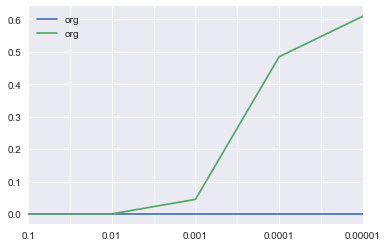

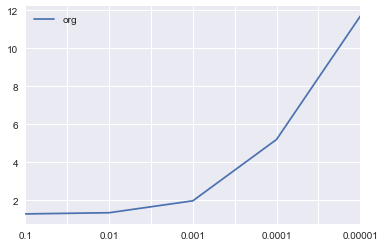

In [34]:
ax = np.transpose(Org_Acc_df).plot()
np.transpose(New_Acc_df).plot(ax=ax)
ax = np.transpose(Fr_Norm_df).plot()

In [8]:
pd.tseries.pylab.show()

AttributeError: module 'pandas.tseries' has no attribute 'pylab'

In [10]:
plt.show()

In [5]:
neg_cosine

NameError: name 'neg_cosine' is not defined

In [10]:
'{:,.1%}'.format(0.037)

'3.7%'